# Model assembly

Wir entschieden uns ein Neuronales Netz zu benutzen, da es uns ermöglicht durch Maschinelles Lernen eine automatische Gewichtung der verschiedenen Eingangsstatistiken zu bestimmen.

## Modellimplementierung

### Imports
Importiert die Bibliotheken PyTorch und Pandas, sowie Matplotlib um Lernkurven graphisch darzustellen.

In [1]:
import time
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt

### Device
Bestimmt ob auf der Grafikkarte oder auf dem Prozessor gerechnet werden soll. Wenn eine CUDA fähige Grafikkarte erkannt wird, wird diese als Rechengerät ausgewählt. Dies spart Rechenzeit im Training, da CUDA Kerne deutlich effizienter in der Berechnung Neuronaler Netze sind.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


### PyTorch Klassen
Definiert eine Klasse für das Datenset und eine für das Neuronale Netzwerk.

Der `network_stack` beschreibt den Aufbau des Netzwerkes. Der erste Netzwerklayer wird mit den 19 Datenpunkten gefüttert, also einen für jedes Feature. In der zweiten Schicht (Hidden Layer) sind nur noch 5 Knoten. Aus groben händischen Tests ergab sich, dass 5 Knoten recht viel versprechend für eine solche Aufgabe sind. Die Aktivierungsfunktion für den Hidden Layer ist die CELu Funktion, da diese positive Werte stark belohnt, negative jedoch nicht auslässt. Sie sieht wie folgt aus.

![img](https://pytorch.org/docs/stable/_images/CELU.png)

Die Hidden Layer leitet die Signale an das Ausgabe Layer weiter, dessen Ausgabe mit einer Sigmoid Funktion aktiviert wird, sodass das Endergebnis zwischen 0 und 1 liegt. Dieses Endergebnis stellt die vorhergesagte Win Rate dar.

In [3]:
class LolProDataset(Dataset):
    def __init__(self, data_file):
        # Preload data into tensors
        data = pd.read_csv(data_file)
        self.labels = torch.tensor(data.pop('Win Rate').to_numpy(), device=device)
        self.features = torch.tensor(data.to_numpy(), device=device)

    def __len__(self):
        # Number of rows in the dataset
        return self.features.shape[0]

    def __getitem__(self, idx):
        # Returns item (features, label) at specific index
        x = self.features[idx]
        y = self.labels[idx]
        return (x, y)

    def split(self, test_rate):
        # Returns number of items for test and train sets by given test_rate
        testc = int(self.__len__()*test_rate)
        trainc = int(self.__len__() - testc)
        return [trainc, testc]

# Implementierung des neuronalen Netzes auf Basis der Vererbung vom nn.Modul
class LolProNetwork(nn.Module):
    def __init__(self):
        super(LolProNetwork, self).__init__()
        self.network_stack = nn.Sequential(
            nn.Linear(19, 5),
            nn.CELU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network_stack(x)

### Train and Test Loops
Loop in dem das Neuronale Netz trainiert und getestet wird. Der mittlere Fehler aus jedem Batch wird genutzt um die Gewichte im Netzwerk im nächsten Batch anzupassen. Mit Backpropagation werden die Errors durch das Netzwerk zurückgeführt und die Gewichte entsprechend angepasst.

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Während der Trainingszeit ausgeführt
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Berechnung des Loss durch die Prediction
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(dataloader, model, loss_fn, optimizer):
    # Wird auf dem trainierten Netzwerk während der Testzeit ausgeführt
    size = len(dataloader.dataset)
    test_loss, err = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()
            err += torch.abs(pred - y.unsqueeze(1)).sum().data
    test_loss /= size
    err /= size
    return (err.item(), test_loss)

### Run Code

Die Epochen beschreiben wie oft das Training mit anderer Batch Reihenfolge durchgeführt werden soll, damit keine Biase
zum Ende des Trainingssatzes entstehen. Also wie oft die Trainingsfunktion auf das Netz ausgeführt werden soll.

Die Größe der der Batches entscheidet wie viele Zeilen für jede Neuberechnung genutzt werden sollen. Größere Batches können zu Underfitting und kleinere zu Overfitting führen. Die Learning Rate ist der Faktor der bestimmt wie weit die Weights in jedem Durchlauf an das vorherige Ergebnis angepasst werden sollen.

In [5]:
lr = 0.0001 # Learning Rate
batch_size = 20 # Batch Größe (Parallel berechnete Zeilen)
epochs = 300 # Epochen (Iterationen)

# Erstelle das Model auf basis des Netzwerks und lasse es auf dem Gerät (cpu oder cuda) berechnen
model = LolProNetwork().to(device).double()

loss_fn = nn.L1Loss() # Mean average Loss function
optimizer = torch.optim.Adam(model.parameters(), lr) # Optimizer

# Load Dataset
dataset = LolProDataset('../data/cleanData.csv')
train_data, test_data = random_split(dataset, dataset.split(0.1), generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Training in jeder Epoche
history = pd.DataFrame([], columns=["Epoch", "MAE", "Loss"])
for t in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer)
    res = test_loop(test_dataloader, model, loss_fn, optimizer)
    history = history.append({"Epoch": t+1, "MAE": res[0], "Loss": res[1]}, ignore_index=True)
    if (t+1)%100 == 0:
        print(f"Epoch {t+1} - MAE: {res[0]}, Loss: {res[1]}")

Epoch 100 - MAE: 0.09936552421776511, Loss: 0.005352931103047146
Epoch 200 - MAE: 0.09582550973994454, Loss: 0.00513000467111408
Epoch 300 - MAE: 0.08900286609921058, Loss: 0.004782446640337478


### Ergebnisse Visualisieren
Mithilfe von Matplotlib werden die Ergebnisse graphisch dargestellt.

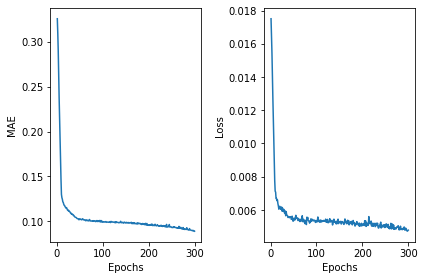

In [6]:
def plotit(history):
    fig, axs = plt.subplots(1, 2)

    axs[0].plot(history['Epoch'], history['MAE'])
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("MAE")
    axs[1].plot(history['Epoch'], history['Loss'])
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")

    fig.tight_layout()

    plt.show()
plotit(history)

Es ist eine deutliche Lernkurve zu erkennen und ein Ergebnis von ca. 8% Abweichung ist auch in Ordnung. Dies lässt sich jedoch noch verbessern.

## Grid Search

Um eine bessere Architektur und bessere Hyperparameter für das Training zu finden benutzen wir eine Grid-Suche, welche verschiedene Kombinationen testet und die Ergebnisse für spätere Analyse speichert. Hierzu wird eine Trainer Funktion implementiert, welche die verschiedenen Netzwerke und Hyperparameter als Parameter entgegen nimmt und diese testet.

In [7]:
def trainer(lr, batch_size, epochs, model, opt, dataset):
    loss_fn = nn.L1Loss() # MAE Loss function
    optimizer = opt(model.parameters(), lr) # Optimizer

    dataset = LolProDataset(dataset)
    train_data, test_data = random_split(dataset, dataset.split(0.1), generator=torch.Generator().manual_seed(42))
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    history = pd.DataFrame([], columns=["Epoch", "MAE", "Loss"])

    print("\n-----------------------------------")
    print(f"\nStart Training with the Parameters:\nlearning rate: {lr}\nbatch size: {batch_size}\noptimizer: {type(optimizer).__name__}\n")
    for t in range(epochs):
        train_loop(train_dataloader, model, loss_fn, optimizer)
        res = test_loop(test_dataloader, model, loss_fn, optimizer)
        history = history.append({"Epoch": t+1, "MAE": res[0], "Loss": res[1]}, ignore_index=True)
    
    print(f"\nSmallest MAE at index {history['MAE'].idxmin()} with:\n{history['MAE'].min()}\n")
    plotit(history)
    print("-----------------------------------\n")
    return history


Nun wird über jede verschiedene Parameter Kombination aus den unten definierten iteriert und mit der Trainer Funktion getestet. Dies dauert eine Weile, da jedes Training sehr Rechenintensiv ist. Die Ergebnisse werden im Unterordner `grid-search-results` gespeichert, um sie auch nach schließen des Notebooks weiter analysieren zu können.

In [8]:
learning_rates = [0.0005, 0.0001, 0.00005]
batch_sizes = [15, 45, 90]
e = 300
optimizer = [torch.optim.Adam, torch.optim.SGD]

results = pd.DataFrame([], columns=["Learning Rate", "Batch Size", "Epochs", "Optimizer", "History", "Min MAE", "Idx Min MAE", "Duration"])
 
for lr in learning_rates:
    for bs in batch_sizes:
        if bs == 1 or bs == 10:
            continue
        for opt in optimizer:
            stime = time.time()
            model = LolProNetwork().to(device).double()
            res = trainer(lr, bs, e, model, opt, '../data/cleanData.csv')
            etime = time.time()
            results = results.append({
                "Learning Rate": lr,
                "Batch Size": bs,
                "Epochs": e,
                "Optimizer": opt,
                "History": res,
                "Min MAE": res['MAE'].min(),
                "Idx Min MAE": res['MAE'].idxmin(),
                "Duration": (etime - stime) * 1000
            }, ignore_index=True)
results.to_pickle('grid-search-results/grid_search_results')
results


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 15
optimizer: Adam



KeyboardInterrupt: 

Mithilfe von Pandas können wir uns das beste Ergebnis ausgeben lassen.

In [ ]:
plotit(results.iloc[results['Min MAE'].idxmin()]['History'])
results['Min MAE'].min()

Ein Blick über andere Kombinationen verrät jedoch, dass ein andere Kombination eventuell viel versprechender sein könnte als diese, wenn wir sie ein wenig länger trainieren lassen.


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 45
optimizer: Adam


Smallest MAE at index 9992 with:
0.062303231744326074



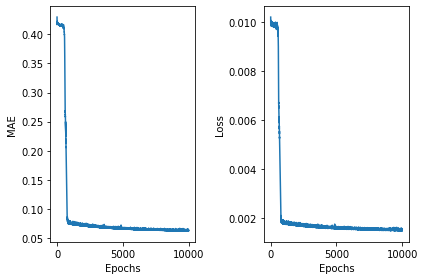

-----------------------------------



In [9]:
lr = 0.00005 # Learning Rate
batch_size = 45 # Batch Size (Parallel calculated rows)
epochs = 10000 # Epochs (iterations over dataset)

model = LolProNetwork().to(device).double()

history = trainer(lr, batch_size, epochs, model, torch.optim.Adam, '../data/cleanData.csv')

Dieses Model performt mit ca. 6.5% Abweichung deutlich besser als das vorherige, es benätigte jedoch sehr viel mehr Trainingszeit als das vorherige. Durch mehr Epochen konnte das Netzwerk immer besser werden. Der Trainingseffekt nimmt jedoch nach einiger Zeit ab und es besteht die Gefahr eines Overfittings. Daher sind 10000 Epochen genügend.

## Beispiel

Hier wird Beispielsweiße ein Datensatz aus dem Datenset entnommen und die entsprechende Win Rate vorhergesagt.

In [10]:
idx = 0
data = pd.read_csv('../data/cleanData.csv')
rates = data.pop('Win Rate')
t1 = torch.tensor(data.iloc[idx].to_numpy(), device=device).double().unsqueeze(0)
t1

tensor([[1.2900e+02, 3.6000e+00, 2.8000e+00, 2.4000e+00, 5.9000e+00, 8.2000e+00,
         4.0000e+02, 5.7200e-01, 2.2400e-01, 4.6900e+02, 3.9000e-01, 2.1000e-01,
         1.4000e-01, 1.3700e+02, 4.0000e+00, 5.0000e+00, 8.5000e-02, 1.0100e-01,
         2.4000e+01]], device='cuda:0', dtype=torch.float64)

In [11]:
rates.iloc[idx]

0.667

In [12]:
model(t1).item()

0.665373623060096

## Modell speichern

Um das Modell in einem Webserver oder ähnlichem wieder zu verwenden wird es gespeichert.

In [15]:
torch.save(model.state_dict(), '../app/model/lol_predicter_v1')